## **Instalation**

In [3]:
!pip install pennylane evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 34.9 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.5/15.5 MB 81.5 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 65.0 MB/s eta 0:00:00


## **Login**

In [2]:
!huggingface-cli login --token ""

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: fineGrained).
Your token has been saved to /root/.cache/huggingface/token
Login successful


## **Imports**

In [45]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import RandomResizedCrop, Compose, Normalize, ToTensor

from tqdm import tqdm
import pennylane as qml
import evaluate
from datasets import load_dataset, load_metric
from transformers import  (AutoModel, AutoConfig, 
                          AutoImageProcessor, 
                          Trainer, TrainingArguments)
from transformers import pipeline

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## **Load the original 33k image dataset**

```java
We wanted to run a last test on the full dataset to prove how good was the solution for generalization
```

In [140]:
# Cargar el dataset
dataset = load_dataset("imagefolder", data_dir="/kaggle/input/womanium-dataset")
dataset = concatenate_datasets([dataset['train'], dataset['test']])

Resolving data files:   0%|          | 0/26666 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/6588 [00:00<?, ?it/s]

```java
The original dataset had 6 classes so we needed to run again the phase 2 for use the dataset and evaluted
```

In [141]:
def add_prefix(example):
    example["label"] = 0 if example["label"] == 2 else 1
    return example

binary_dataset = dataset.map(add_prefix)

Dataset({
    features: ['image', 'label', 'prediction_Fraunhofer_Classical'],
    num_rows: 33254
})

```java
We store the labels so we can do multiple evaluations
```

In [142]:
labels = binary_dataset["label"]

## **Predictions model 1**


```java
In the following two cells, we build a small pipeline to obtain predictions for the entire dataset using the classical model.
```

In [143]:
# Modelo 1
model_name_1 = "Fraunhofer_Classical"
classifier_model_1 = pipeline("image-classification", model=f"LaLegumbreArtificial/{model_name_1}", device=device)
prediction_label_1 = f"prediction_{model_name_1}"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def add_prediction_1(example):
    results = classifier_model_1(example["image"])
    max_score_label = max(results, key=lambda x: x['score'])['label']
    example[prediction_label_1] = 0 if max_score_label == 'GOOD' else 1
    return example

binary_dataset = binary_dataset.map(add_prediction_1)

Map:   0%|          | 0/33254 [00:00<?, ? examples/s]

In [145]:
predictions_classical = binary_dataset["prediction_Fraunhofer_Classical"]

## **Predictions model 2**

```javascript
Because at the moment the hugging face interface does not support quantum layers, so the way to make predictions is a bit longer, we need first to preprocess the images, then load the pythorch model and after that use the same pipeline function as before with some slight modificatons
```

In [35]:
model_checkpoint = "microsoft/beit-base-patch16-224-pt22k-ft22k"
image_processor  = AutoImageProcessor.from_pretrained(model_checkpoint)


normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
size = (
    image_processor.size["shortest_edge"]
    if "shortest_edge" in image_processor.size
    else (image_processor.size["height"], image_processor.size["width"])
)
_transforms = Compose([RandomResizedCrop(size), ToTensor(), normalize])

def transforms(examples):
    examples["pixel_values"] = [_transforms(img.convert("RGB")) for img in examples["image"]]
    return examples

preprocessor_config.json:   0%|          | 0.00/276 [00:00<?, ?B/s]

In [77]:
binary_dataset = binary_dataset.with_transform(transforms)

In [16]:
n_qubits = 2
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev)
def qnode(inputs, weights):
    qml.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.BasicEntanglerLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]


n_layers = 6
weight_shapes = {"weights": (n_layers, n_qubits)}

qlayer = qml.qnn.TorchLayer(qnode, weight_shapes)

class CustomVisionModel(nn.Module):
    def __init__(self, checkpoint, num_labels):
        super(CustomVisionModel, self).__init__()
        self.num_labels = num_labels

        # Cargar el modelo con el checkpoint dado y extraer su cuerpo
        self.config = AutoConfig.from_pretrained(checkpoint, output_attentions=True, output_hidden_states=True)
        self.model = AutoModel.from_pretrained(checkpoint, config=self.config)
        self.dropout = nn.Dropout(0.1)
        self.dense1 = nn.Linear(self.config.hidden_size, num_labels)
        self.qlayer = qml.qnn.TorchLayer(qnode, weight_shapes)


    def forward(self, pixel_values=None, labels=None):
        if pixel_values is None:
            raise ValueError("Debe proporcionar 'pixel_values' para modelos de visión.")

        # Extraer salidas del cuerpo del modelo
        outputs = self.model(pixel_values=pixel_values)
        pooled_output = outputs.pooler_output  # pooler_output es la representación de la imagen completa

        # Agregar capas personalizadas
        dropout_output = self.dropout(pooled_output)
        dense_output = self.dense1(dropout_output)
        logits = self.qlayer(dense_output)

        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))

        if loss is not None:
            return loss, logits
        else:
            return logits

# Configuración de los parámetros
num_labels = 2
learning_rate = 2e-5
num_epochs = 5

# Inicializar el modelo, el optimizador y la función de pérdida
model = CustomVisionModel(checkpoint=checkpoint, num_labels=num_labels)


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Modelo 2
model_name_2 = "Fraunhofer_Hybrid"
classifier_model_2 = CustomVisionModel(checkpoint=checkpoint, num_labels=num_labels)
classifier_model_2.load_state_dict(torch.load("model_weights.pth"))
classifier_model_2.to(device)
classifier_model_2.eval()  # Set the model to evaluation mode

prediction_label_2 = f"prediction_{model_name_2}"

def add_prediction_2(example):
    with torch.no_grad():
        pixel_values = example["pixel_values"].to(device)
        outputs = classifier_model_2(pixel_values=pixel_values.reshape(1,3,224,224))
        logits = outputs if isinstance(outputs, torch.Tensor) else outputs[1]
        predictions = torch.argmax(logits, dim=-1)
        example[prediction_label_2] = predictions
    return example

binary_dataset = binary_dataset.map(add_prediction_2)


## **Alert**

```java
ALERT: Due to a bug we identified in the Hugging Face library, we were unable to directly access the labels from these predictions. To work around this issue, we implemented a method to access the predictions one by one. However, this approach is slower, so we recommend either skipping the next cell or allowing it to run if you have the time.
```

In [87]:
predictions_hybrid = []
for i in range(len(binary_dataset)):
    predictions_hybrid.append(binary_dataset[i]["prediction_Fraunhofer_Classical"][0])
    if i % 100 == 0:
        print(i)
    

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
18100
18200
18300
18400
18

## **Final results**


```javascript
This bar chart compares the performance of two models—a classical transformer (blue) and a quantum-enhanced transformer (orange)—across five evaluation metrics: Accuracy, Precision, Recall, F1-Score, and ROC AUC. The classical model consistently performs slightly better across all metrics, with scores very close to 1. The quantum-enhanced model shows slightly lower scores in each metric, indicating that while it is still very effective, it doesn't outperform the classical model in this instance.
```

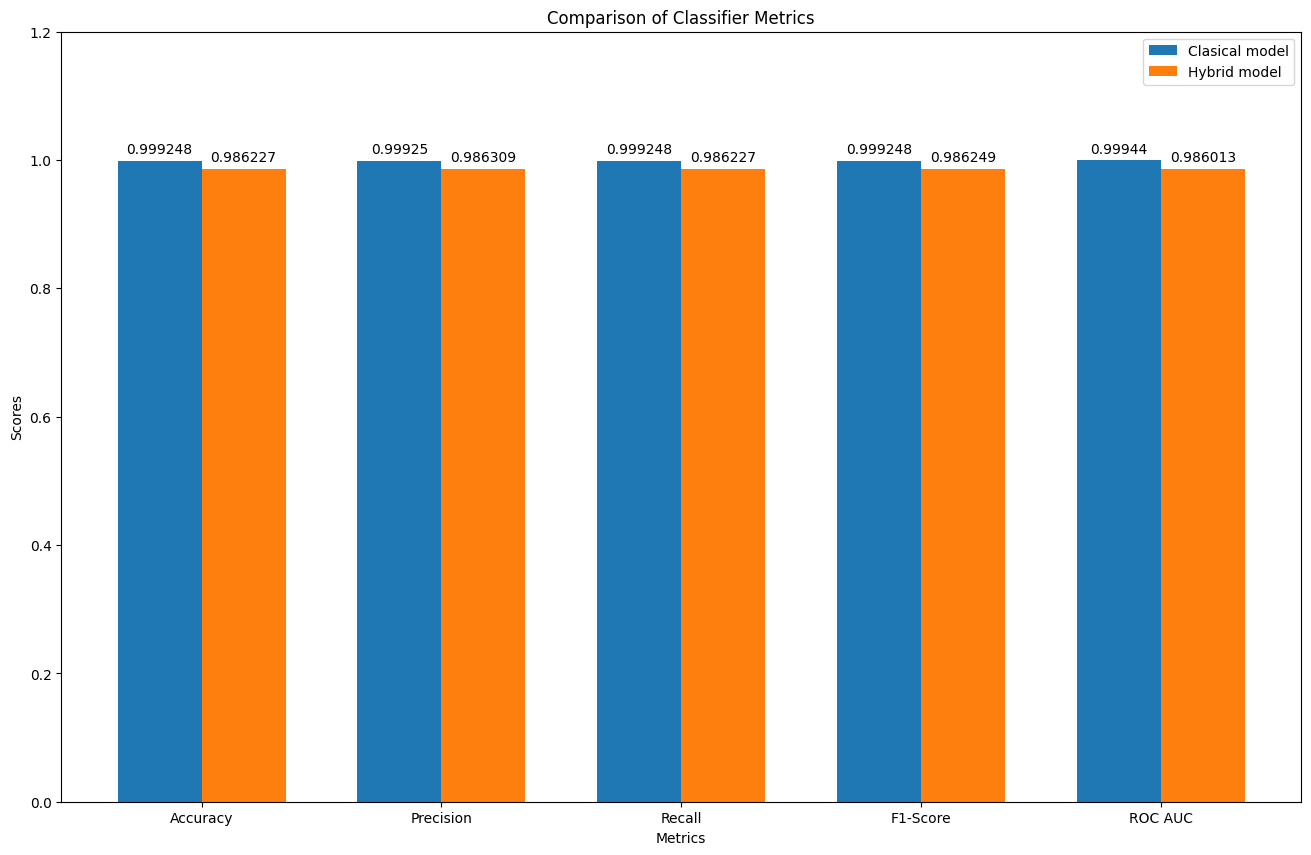

In [146]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report

# Suponiendo que tienes las etiquetas verdaderas y las predicciones
y_true = labels # Etiquetas verdaderas
y_pred_1 = predictions_classical  # Predicciones del clasificador 1
y_pred_2 = predictions # Predicciones del clasificador 2

name_classical = "Clasical model"
name_hybrid = "Hybrid model"

def evaluate_classifier(y_true, y_pred):
    metrics = {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred, average='weighted'),
        "Recall": recall_score(y_true, y_pred, average='weighted'),
        "F1-Score": f1_score(y_true, y_pred, average='weighted'),
        "ROC AUC": roc_auc_score(y_true, y_pred, average='weighted'),
    }
    return metrics

def plot_metrics(metrics_1, metrics_2, labels):
    x = np.arange(len(labels))
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots(figsize=(16, 10))
    bars1 = ax.bar(x - width/2, [metrics_1[label] for label in labels], width, label=name_classical)
    bars2 = ax.bar(x + width/2, [metrics_2[label] for label in labels], width, label=name_hybrid)

    ax.set_xlabel('Metrics')
    ax.set_ylabel('Scores')
    ax.set_title('Comparison of Classifier Metrics')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    for bars in [bars1, bars2]:
        ax.bar_label(bars, padding=3)

    plt.ylim(0, 1.2)  # Set the y-axis range to 0-1 for better visualization
    plt.show()

# Evaluate classifiers
metrics_1 = evaluate_classifier(y_true, y_pred_1)
metrics_2 = evaluate_classifier(y_true, y_pred_2)

# Plot the metrics
metrics = list(metrics_1.keys())
plot_metrics(metrics_1, metrics_2, metrics)


```java
The classical model has fewer errors and higher precision in classifying both classes, while the hybrid model shows more misclassifications, particularly in distinguishing between the two classes.
```

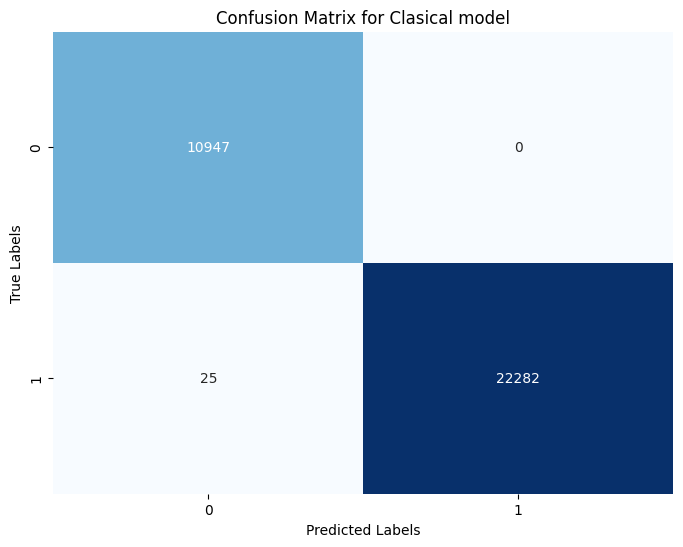

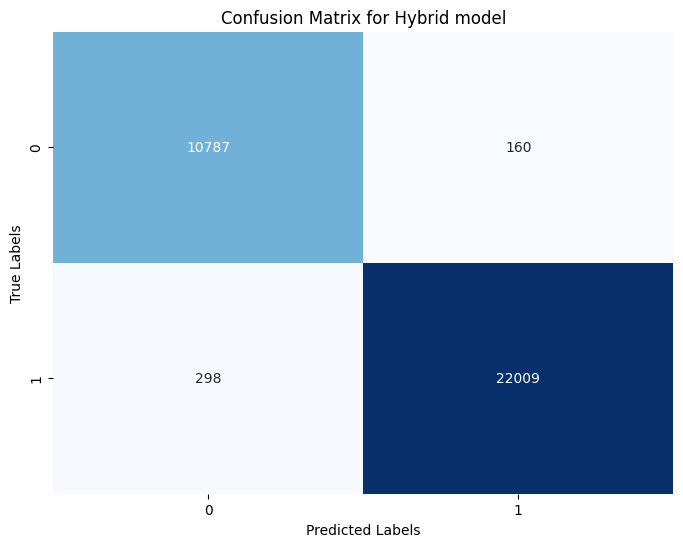

In [148]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(title)
    plt.show()

# Plot confusion matrix for classifier 1
plot_confusion_matrix(y_true, y_pred_1, 'Confusion Matrix for Clasical model')

# Plot confusion matrix for classifier 2
plot_confusion_matrix(y_true, y_pred_2, 'Confusion Matrix for Hybrid model')